## Visual search experiment

This is a very short visual search experiment. Per trial, participants are first presented with a sentence that contains a description of the target (a shape with a color, e.g. green triangle). When they press the space bar, a display appears that contains multiple distractors that look like the target in terms of shape or color. The distractor ratio is either equal (as many color distractors as shape distractors) or unequal (more color than shape distractors). Participants have to respond as fast as possible when they detect the presence or absence of the target. Both their reaction time and the correctness of their response is saved. By analyzing how fast participants responded, we can get an idea of how they searched through the screen looking for the target (in my actual experiment, I also look at other language-related factors).  

### Read inputfile, run experiment, write outputfile 
The inputfile contains the name of the target, the name of the display (including distractor ratio; either equal or unequal) and whether the target is present in the display (y) or not (n).

In [1]:
import subprocess as sp
sp.run(['python', 'Visual search.py'])

CompletedProcess(args=['python', 'Visual search.py'], returncode=0)

### Read and clean the data

In [6]:
import pandas as pd
# read in a comma-separated file; add header manually
data = pd.read_csv('answers.csv', sep = ',', names = ['-', 'Answer', 'Correctness', 'Condition', 'RT', '--']) 

#check for missing values
data.isnull().sum()
#drop rows with missing values
#cleaneddata = data.dropna()

#drop additional columns that were empty
cleaneddata = data.drop(['-', '--'], axis = 1)

#drop rows with incorrect responses
cleaneddata = cleaneddata[cleaneddata.Correctness != 'incorrect']
#doesn't work? -> manually drop incorrect responses
#cleaneddata = cleaneddata.drop(cleaneddata.index[6])

cleaneddata


,Answer,Correctness,Condition,RT
0,'n','correct','un',1093.148000
1,'y','correct','eq',652.886976
2,'y','correct','eq',624.701108
3,'n','correct','un',923.333051
4,'y','correct','eq',676.077150
5,'y','correct','un',1009.435036
6,'n','incorrect','eq',1352.097548
7,'y','incorrect','un',1291.145496
8,'n','correct','un',701.060751
9,'y','correct','eq',859.057378


### Run regression model on RT data

In [3]:
from sklearn import linear_model
from sklearn.metrics import r2_score

#model data as a function of Condition
data = cleaneddata.drop(['Answer', 'Correctness', 'RT'], axis = 1)
#dummy code the categorical variable Condition (eq = equal, un = unequal)
datadum = pd.get_dummies(data)

print(datadum)

    Condition_ 'eq'  Condition_ 'un'
0                 0                1
1                 1                0
2                 1                0
3                 0                1
4                 1                0
5                 0                1
6                 1                0
7                 0                1
8                 0                1
9                 1                0
10                0                1
11                0                1
12                1                0
13                0                1
14                1                0
15                0                1
16                0                1
17                1                0


In [4]:
y = cleaneddata['RT']

model = linear_model.LinearRegression() 
model.fit(datadum, y)                            # fit the model betas
y_predicted = model.predict(datadum)             # predict y from X
r2 = r2_score(y, y_predicted)                    # calculate model R-squared

print(f'R-squared is {r2}') #wow that's really bad...

R-squared is 0.009600346219619027


### Plot the data

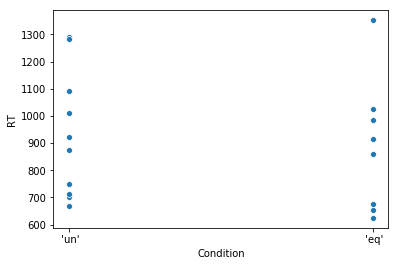

In [7]:
import seaborn as sns

#have a look at the response times as a function of condition
sns.scatterplot(x = 'Condition', y = 'RT', data=cleaneddata)

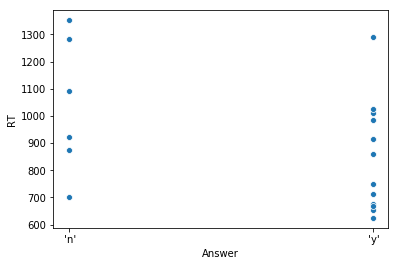

In [8]:
#plot response times as a function of answer
sns.scatterplot(x = 'Answer', y = 'RT', data=cleaneddata)

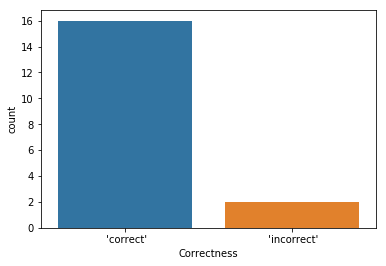

In [9]:
#plot the number of correct and incorrect responses
sns.countplot(x ='Correctness', data=cleaneddata)

### Additional note

The experiment above is a stripped version of the behavioral experiment that I am currently running, in which I analyze the effect of the structure of the input phrase on RTs as a function of display type (where the displays are more complex than they are in the experiment above). This experiment has been created in Presentation, where I load each individual object (which has size, color, shape) separately based on an inputlist, instead of using pre-created images (as done here).

Beforehand, I specified the content of this inputlist (dependent on distractor ratio) and the position of the target in a textfile. The  positions of the distractors still had to be randomized, which is what the following script does. In the inputlist the target is specified twice: once in a separate column and once in the pre-specified column corresponding to a position in the display. This script randomizes all items that are not the same as the target (i.e. all distractors). When it sees the target, it doesn't run the randomization function but keeps this target in the column that corresponds to the pre-specified target position.

In [ ]:
import random

#open the inputlist
with open('nonrandlist.txt', 'r') as inp_list: #make sure inputfile does not have header
    inp_list = inp_list.read()
    inp_lines = inp_list.split('\n')

    inp_columns = []

    #save the columns so that they can be indexed
    for lines in range(len(inp_lines)):
        columns = inp_lines[lines].split('\t')
        inp_columns.append(columns)
        
def randomize(a):

    c = [[] for y in range(1) for z in range(len(inp_lines))]
    
    for line in range(len(inp_columns)):
        
        myPositions = []
        
        #the target object is specified twice
        for j in range(17): #16 objects + 1 target in specific column
            if j == 0:
                myPositions.append(a[line][1])
            else:
                myPositions.append(a[line][j + 4])
                
        c[line].append(a[line][1])
        
        for i in range(len(a[line][4:20])):
            
            if a[line][i + 5] == a[line][1]:
                c[line].append(a[line][i + 5]) 
        
            elif a[line][i + 5] != a[line][1]:  
                element = random.choice(myPositions[1:])
            
                myPosNoTarget = myPositions[1:]
                if element == a[line][1]:
                    myPosNoTarget.remove(element)
                    element = None
                    element = random.choice(myPosNoTarget[:])
        
                myPositions.remove(element)       
                
                c[line].append(element)           

    return c

c = randomize(inp_columns)

# write to outputfile; can be opened in excel (delimit on commas)
with open('randlist.txt', 'w') as outp_list:
    for item in c:
        outp_list.write("%s\n" % item)